# Access Data4Human Sentinel-1 Floodmasks

In [5]:
import folium
import folium.plugins as plugins
import geopandas as gpd

from odc.stac import stac_load
from pystac_client import Client
from shapely.geometry import shape

import pystac

## Query STAC API
The easiest way to work with the data is to use the [Geoservice STAC API](https://geoservice.dlr.de/eoc/ogc/stac). The Data4Human Sentinel-1 Floodmasks are located in the [D4H collection](https://geoservice.dlr.de/eoc/ogc/stac/collections/D4H). In the following we use [pystac-client](https://github.com/stac-utils/pystac-client) to query the items in this collections by bounding box (*bbox*) and acquisition dates (*dates_from_to*). Optionally, we can also filter the items by properties such as when they have been updated.

In [6]:
# search stac api
stacapi_endpoint = "https://geoservice.dlr.de/eoc/ogc/stac"
collections = ["D4H"]
bbox = [33.0826, -24.9789, 40.9334, -13.3956]
dates_from_to = ["2021-01-01", "2021-01-31"]
filt = None #"updated > '2022-02-20T00:00:00.000' AND updated < '2022-02-28T10:00:00.000'"

catalog = Client.open(
    url=stacapi_endpoint,
    ignore_conformance=True
)

search = catalog.search(
    collections=collections, 
    bbox=bbox, 
    datetime=dates_from_to, 
    filter=filt, 
    method="GET", 
    filter_lang="cql2-text",
    max_items=3000
)

items = [item for item in search.get_items()]
print(f"Search returned {len(items)} items")

Search returned 130 items


## Convert items to Geopandas Dataframe
We can convert the pystac items to a Geopandas Dataframe for further vector analysis or simply to save them to file in a range of GIS file formats.

In [7]:
items_dict = [item.to_dict() for item in items]
items_gdf = gpd.GeoDataFrame.from_features(items_dict)
items_gdf.head(3)

,geometry,created,updated,datetime,start_datetime,end_datetime,platform,constellation,instruments,proj:epsg,sat:relative_orbit,sat:orbit_state,processing:software,providers,cnt_flood,cnt_valid,cnt_water,cnt_refwater,srcurl,srcuuid
0,"POLYGON ((34.54520 -17.29770, 34.54840 -17.297...",2022-02-18T13:41:45.105+00:00,2022-02-18T13:41:45.105+00:00,2021-01-31T16:15:41Z,2021-01-31T16:15:41.000+00:00,2021-01-31T16:16:06.000+00:00,SENTINEL-1A,SENTINEL-1,[C-SAR],4326,25400,ASCENDING,{'proc_hr_semseg': '1.5.5'},"[{'name': 'DLR DFD-GZS', 'roles': ['producer',...",132881,117211551,138515,5634,https://apihub.copernicus.eu/apihub/odata/v1/P...,eb9dab31-c851-4c16-8dbb-a8d6f2807e34
1,"POLYGON ((34.88970 -18.61530, 34.93250 -18.783...",2022-02-18T13:55:40.322+00:00,2022-02-18T13:55:40.322+00:00,2021-01-31T16:15:16Z,2021-01-31T16:15:16.000+00:00,2021-01-31T16:15:41.000+00:00,SENTINEL-1A,SENTINEL-1,[C-SAR],4326,25400,ASCENDING,{'proc_hr_semseg': '1.5.5'},"[{'name': 'DLR DFD-GZS', 'roles': ['producer',...",5613851,244548643,12948057,7334206,https://apihub.copernicus.eu/apihub/odata/v1/P...,a908cfcf-46f4-47f1-8b07-20ac4064d09f
2,"POLYGON ((35.06870 -21.60500, 34.47070 -21.747...",2022-02-18T13:57:11.570+00:00,2022-02-18T13:57:11.570+00:00,2021-01-31T16:14:51Z,2021-01-31T16:14:51.000+00:00,2021-01-31T16:15:16.000+00:00,SENTINEL-1A,SENTINEL-1,[C-SAR],4326,25400,ASCENDING,{'proc_hr_semseg': '1.5.5'},"[{'name': 'DLR DFD-GZS', 'roles': ['producer',...",5168197,303177925,34050038,28881841,https://apihub.copernicus.eu/apihub/odata/v1/P...,34e2e727-8036-43d8-a776-baec8861bbe7


## Visualize item footprints on map
We can use the Geopandas Dataframe to easily visualize the item footprints on an interactive Leaflet (Folium) map.

In [9]:
m = folium.Map(tiles="Stamen Terrain")
layer_control = folium.LayerControl(position="topright", collapsed=True)
fullscreen = folium.plugins.Fullscreen()
marker_cluster = folium.plugins.MarkerCluster(name="Item markers").add_to(m)

for item in items:
    geom_pt = shape(item.geometry).representative_point()
    folium.Marker(
        [geom_pt.y, geom_pt.x], 
        popup=f"<a href={item.links[4].target} target='_blank' rel='noopener noreferrer'>{item.id}</a><br>"
        f"platform: {item.properties['platform']}<br>"
        f"datetime: {item.datetime}<br>"
        f"cnt_water: {item.properties['cnt_water']}"
    ).add_to(marker_cluster)
    
style = {"fillColor": '#00000000', "color": "#0000ff", "weight": 1}

footprints = folium.GeoJson(
    items_gdf.to_json(), 
    name="Item footprints", 
    style_function=lambda x: style,
    control=True
)

footprints.add_to(m)
layer_control.add_to(m)
fullscreen.add_to(m)
m.fit_bounds(m.get_bounds())
m 

## Convert items to Xarray Dataset
We can convert the pystac items to a Xarray Dataset for further raster analysis, such as timeseries analysis or mosaicing. Note that here we set a low resolution for faster visualization (the native resolution of the products is 0.0001).

In [10]:
items_ds = stac_load(
    items,
    bands=["WATER", "VALID"],
    crs="EPSG:4326",
    resolution=0.01,
    lon=(bbox[0], bbox[2]),
    lat=(bbox[1], bbox[3]),
    skip_broken_datasets=True,
)  
print(items_ds)

<xarray.Dataset>
Dimensions:      (time: 128, latitude: 1159, longitude: 786)
Coordinates:
  * time         (time) datetime64[ns] 2021-01-01T16:14:43.500000 ... 2021-01...
  * latitude     (latitude) float64 -13.4 -13.41 -13.42 ... -24.96 -24.97 -24.98
  * longitude    (longitude) float64 33.09 33.09 33.11 ... 40.91 40.92 40.94
    spatial_ref  int32 4326
Data variables:
    WATER        (time, latitude, longitude) uint16 0 0 0 0 0 0 ... 0 0 0 0 0 0
    VALID        (time, latitude, longitude) uint16 0 0 0 0 0 0 ... 0 0 0 0 0 0
Attributes:
    crs:           EPSG:4326
    grid_mapping:  spatial_ref


## Compute coverage (number of valid observations) from valid mask assets
Each item has several assets assigned to it. For the Data4Human Sentinel-1 Floodmasks the assets are:

- "VALID": Valid pixel mask
- "WATER": Water mask
- "REFER": Reference water mask

In the following we use the valid pixel mask assets to compute the number of valid observations per pixel, which provides us with an efficient way to get the satellite coverage for the given area and time of interest.

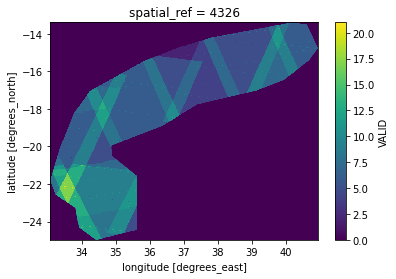

In [11]:
# sum valid masks along time dimension to compute number of valid observations
coverage = items_ds["VALID"].sum(dim="time")

# plot coveragemask
coverage.plot()

## Create mosaic from water mask assets
Here we get the maximum value along time dimension to mosaic all water masks assets.

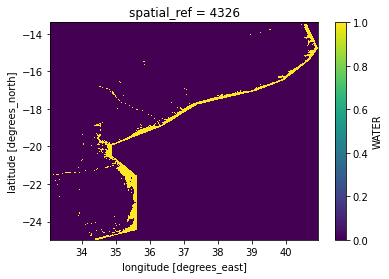

In [12]:
# get maximum value along time dimension to mosaic water masks
mosaic = items_ds["WATER"].max(dim="time")

# plot mosaic
mosaic.plot()

## Visualize water mask from WMS
Besides the STAC API endpoint, we can also use common OGC webservices such as Web Map Service (WMS) to interact with the products on Geoservice. In the following we simply load a WMS layer of the water mask for a desired timestamp. Please note that this examples requires the exact timestamp of a product. There are, however, more convenient tools and Leaflet Plugins available that allow to specify dates or date ranges instead.

In [13]:
# NOTE: this requires the exact timestamp and accepts a list of timestamps seems
m = folium.Map(tiles="Stamen Terrain")
watermask = folium.raster_layers.WmsTileLayer(
    url = "https://geoservice.dlr.de/eoc/demo/wms?", 
    layers="D4H_WATER_MASK_S1", 
    time='2022-02-21T03:02:11Z', #f"{dates_from_to[0]}T00:00:00Z",
    #bounds=[[bbox[1], bbox[0]], [bbox[3], bbox[2]]],
    fmt='image/png', 
    transparent=True, 
    version='1.1.1',
    name="Water mask",
    control=True
)
watermask.add_to(m)
fullscreen.add_to(m)
m.fit_bounds(footprints.get_bounds())
m